# Context-specific metabolic networks from omics

Here we will illustrate the use of the iMAT method, as implemented in CORNETO, to extract context specific metabolic networks from transcriptomics. CORNETO implements an extension of iMAT to support multiple samples, and also gives more control for customization.

We will use the core [E. coli PKN](https://systemsbiology.ucsd.edu/Downloads/E_coli_Core), and microarray-based gene [expression data]( http://systemsbiology.ucsd.edu/InSilicoOrganisms/Ecoli/EcoliExpression2) corresponding to a anaerobic growth on glucose of a wild-type E. coli strain. This tutorial is based on the original [COBRA tutorial](https://opencobra.github.io/cobratoolbox/stable/tutorials/tutorial_extractionTranscriptomic.html).


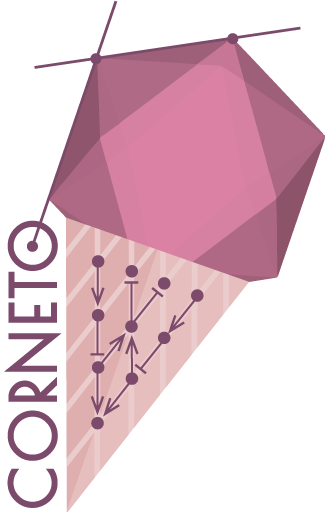

In [1]:
import numpy as np
import pandas as pd

import corneto as cn

cn.info()

In [2]:
from corneto.methods.future.imat import MultiSampleIMAT

MultiSampleIMAT.show_citations()

## Loading data from COBRA

We will use the ecoli core metabolic network and ecoli data example obtained from the COBRA package. This dataset contains 4 biological replicates. In this tutorial, we will use the single sample iMAT, we will average the expression and use this for analysis, since we are not interesed in analysing differences of the replicates

In [3]:
from corneto.io import import_cobra_model

G = import_cobra_model("../../tests/gem/ecoli_core.zip")
df_expr = pd.read_csv("../../tests/gem/ecoli_example_data.zip")
df_expr

,gene,raw_value_1,raw_value_2,raw_value_3,raw_value_4,value
0,b0008,11.211265,12.030984,12.017371,11.674179,11.733450
1,b0114,11.767118,11.581649,11.885833,11.571045,11.701411
2,b0115,11.020531,10.813589,11.144573,11.362138,11.085208
3,b0116,10.299068,10.562963,10.788094,10.425459,10.518896
4,b0118,6.116122,6.437554,6.956686,6.229419,6.434945
...,...,...,...,...,...,...
131,b4153,9.647255,10.089110,8.685851,8.902372,9.331147
132,b4154,9.176739,9.387545,8.841818,8.510611,8.979178
133,b4232,9.490210,9.201019,9.321175,9.235511,9.311979
134,b4301,2.335597,2.338372,2.317967,2.270161,2.315524


In [4]:
G.shape

(77, 91)

In [5]:
# We can inspect the content of the network
G.get_attr_edges()[:5]

[{'__edge_type': 'directed',
  'id': 'EX_ac_b',
  '__source_attr': {'ac_b': {'__value': -1.0}},
  '__target_attr': {},
  'default_lb': -1000.0,
  'default_ub': 1000.0,
  'GPR': ''},
 {'__edge_type': 'directed',
  'id': 'EX_akg_b',
  '__source_attr': {'akg_b': {'__value': -1.0}},
  '__target_attr': {},
  'default_lb': -1000.0,
  'default_ub': 1000.0,
  'GPR': ''},
 {'__edge_type': 'directed',
  'id': 'EX_co2_b',
  '__source_attr': {'co2_b': {'__value': -1.0}},
  '__target_attr': {},
  'default_lb': -1000.0,
  'default_ub': 1000.0,
  'GPR': ''},
 {'__edge_type': 'directed',
  'id': 'EX_etoh_b',
  '__source_attr': {'etoh_b': {'__value': -1.0}},
  '__target_attr': {},
  'default_lb': -1000.0,
  'default_ub': 1000.0,
  'GPR': ''},
 {'__edge_type': 'directed',
  'id': 'EX_for_b',
  '__source_attr': {'for_b': {'__value': -1.0}},
  '__target_attr': {},
  'default_lb': -1000.0,
  'default_ub': 1000.0,
  'GPR': ''}]

## Mapping data using Gene-Protein-Reaction (GPR) rules

We need to compute reaction scores from gene expression data. For this, we will classify genes as highly expressed and lowly expressed based on thresholds applied to the marginal distribution of gene intensities. Then, we will map these values by applying the Gene-Protein-Reaction (GPR) rules included in the Ecoli PKN.

In [6]:
from corneto.methods.metabolism import evaluate_gpr_expression, get_unique_genes

genes = get_unique_genes(G, startswith="b")
len(genes)

101

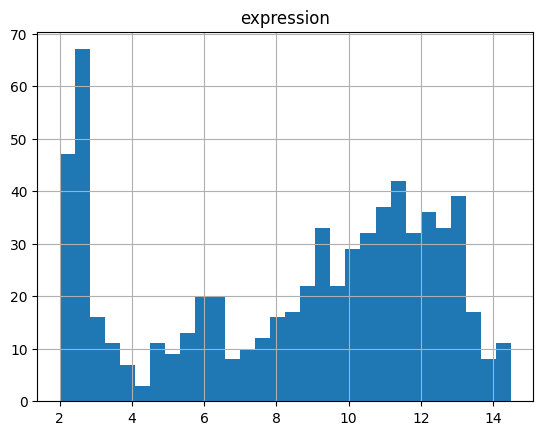

In [7]:
df_expr.set_index("gene").stack().to_frame(name="expression").hist(bins=30);

In [8]:
df_expr["high"] = (df_expr["value"] >= 8).astype(int)
df_expr["low"] = (df_expr["value"] <= 4).astype(int)
df_expr["score"] = df_expr["high"] - df_expr["low"]
df_expr

,gene,raw_value_1,raw_value_2,raw_value_3,raw_value_4,value,high,low,score
0,b0008,11.211265,12.030984,12.017371,11.674179,11.733450,1,0,1
1,b0114,11.767118,11.581649,11.885833,11.571045,11.701411,1,0,1
2,b0115,11.020531,10.813589,11.144573,11.362138,11.085208,1,0,1
3,b0116,10.299068,10.562963,10.788094,10.425459,10.518896,1,0,1
4,b0118,6.116122,6.437554,6.956686,6.229419,6.434945,0,0,0
...,...,...,...,...,...,...,...,...,...
131,b4153,9.647255,10.089110,8.685851,8.902372,9.331147,1,0,1
132,b4154,9.176739,9.387545,8.841818,8.510611,8.979178,1,0,1
133,b4232,9.490210,9.201019,9.321175,9.235511,9.311979,1,0,1
134,b4301,2.335597,2.338372,2.317967,2.270161,2.315524,0,1,-1


In [9]:
values = df_expr[["gene", "score"]].set_index("gene").to_dict()["score"]
e = evaluate_gpr_expression(G.get_attr_from_edges("GPR"), values)

In [10]:
pd.DataFrame({"id": G.get_attr_from_edges("id"), "score": e})

,id,score
0,EX_ac_b,0
1,EX_akg_b,0
2,EX_co2_b,0
3,EX_etoh_b,0
4,EX_for_b,0
...,...,...
86,TALA,1
87,THD2,1
88,TKT1,1
89,TKT2,1


## Context-specific network inference

We will use the reaction scores to create a `Data` object. The `id` corresponds to the reaction id of the PKN, and the value to the reaction score. We indicate that these features map to edges (reactions) with `mapping` = `edge`. Note that if `mapping` = `none`, then it will be assumed that the dataset contains genes, and automatic GPR will be performed to translate from genes to reaction scores.

In [11]:
# Create a dataset (here we only have 1 sample, which is the mean of the four measurements)
from corneto._data import Data

feats = dict()
for edge, val in zip(G.get_attr_from_edges("id"), e):
    feats[edge] = {"value": val, "mapping": "edge"}
data = {"sample1": feats}
data = Data.from_cdict(data)
data

Data(n_samples=1, n_feats=[91])

We run the iMAT method (in this case, only 1 sample, which is the mean of the 4 biological replicates)

In [12]:
# eps is the min absolute flux value that we will consider
# for reactions with positive scores, i.e., if a reaction
# with a positive score is included in the context specific
# metabolic network, it has to be able to carry an absolute
# metabolic flux value above eps.
eps = 1e-2

# We will also add a small penalty to make networks sparser.
# When we have more than 1 sample, this parameter controls
# the regularization across samples, blocking entire groups
# of reactions across samples. Here, we are just penalizing
# the inclusion of reactions not needed to fit the reaction
# scores
m = MultiSampleIMAT(lambda_reg=1e-3, eps=eps)
P = m.build(G, data)
P.expr

{'_flow': _flow: Variable((91,), _flow),
 '_flow_ipos': _flow_ipos: Variable((91,), _flow_ipos, boolean=True),
 '_flow_ineg': _flow_ineg: Variable((91,), _flow_ineg, boolean=True),
 'edge_has_flux': edge_has_flux: Variable((91,), edge_has_flux, boolean=True),
 'flow': _flow: Variable((91,), _flow)}

In [13]:
P.solve(solver="scipy", verbosity=0);

The final result indicates that 1 reaction with positive score was not selected, and 1 reaction with negative score was included. In total, the network contains 61 reactions with fluxes. The last value corresponds to the number of reactions that were not blocked.

In [14]:
for o in P.objectives:
    print(o.value)

1.0
1.0
61.0


In [15]:
# Metabolic fluxes correspond to values of the flow variable
# Note that there are 91 values, corresponding to the 91 reactions
# in the PKN

df_sol = pd.DataFrame(
    P.expr.flow.value, index=G.get_attr_from_edges("id"), columns=["flux"]
)
df_sol

,flux
EX_ac_b,5.226570e-02
EX_akg_b,-5.204170e-18
EX_co2_b,1.108361e+01
EX_etoh_b,1.123012e+01
EX_for_b,4.553438e-01
...,...
TALA,-1.000000e-02
THD2,5.008158e+00
TKT1,-1.000000e-02
TKT2,-3.690516e-02


array([[<Axes: title={'center': 'flux'}>]], dtype=object)

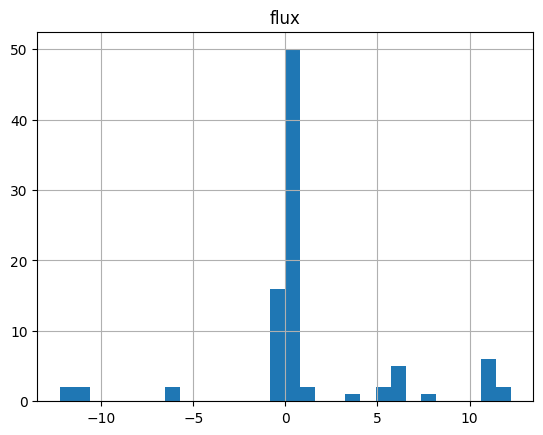

In [16]:
df_sol.hist(bins=30)

In [17]:
selected_reactions = df_sol[df_sol.flux.abs() >= eps * (1 - eps)].index.values.tolist()
len(selected_reactions)

61

In [18]:
np.sum(P.expr.edge_has_flux.value)

61.0

In [19]:
# Extract the context specific network
G_ctx = G.edge_subgraph(np.flatnonzero(P.expr.edge_has_flux.value))
G_ctx.shape

(57, 61)

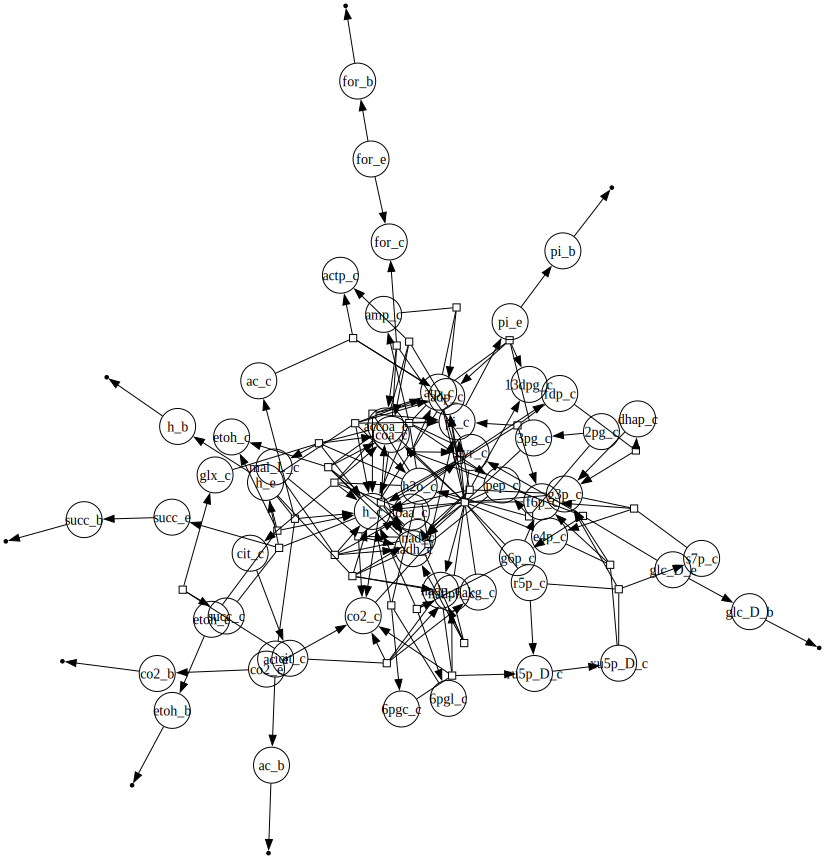

In [20]:
G_ctx.plot(layout="neato")

## Old version

Original experiments in the manuscript used the old `multicondition_imat`:

In [21]:
from corneto.methods.metabolism.fba import multicondition_imat

P = multicondition_imat(G, np.array(e), alpha=1e-3, eps=eps)
P.solve(solver="scipy");

In [22]:
for o in P.objectives:
    print(o.value)

2.0
60.0


## Citations

In [23]:
MultiSampleIMAT.show_bibtex()